## General info:

Data from [MTA](http://web.mta.info/developers/turnstile.html) <br>
Description of data [here](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)


[GitHub for this project](https://github.com/huge-reality/MTA_Project_Group_5)



## Steps undertaken in this notebook
1. Read one week's worth of data, clean up column names
2. Add datetime elaborated info
3. Mask to only look at two times (8 AM and 12 PM to start)
4. Make two diff columns, entries and exits
    - Group by 'UNIT' and 'SCP'
5. Combine the entry and exit columns because they represent total traffic
    - We don't care if people are coming or going, just that they're there
6. Brute force clean up the difference data
7. Make a new dataframe that aggregates a groupby based on 'STATION'
    - The sum of the entry/exit 
8. REPEAT THE ABOVE STEPS 1-7 for 12PM - 4PM and 4PM - 8 PM
9. Make a new dataframe that has the total entries/exits for AM, midday, and PM
10. Two new columns: 1. Subtract midday from AM and 2. Subtract midday from PM
11. Filter that new dataframe to *only* include values that are high for both am vs. midday and pm vs. midday

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [6]:
# read the data and remove spaces from column names
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

am = df1.append([df2, df3])

am.columns = am.columns.str.strip()


# add in two new columns, one that is a datetime (from the date and time columns)
# and one that is just the day of the week
am['DATETIME'] = am['DATE'] + ' ' + am['TIME']
am['DATETIME'] = pd.to_datetime(am['DATETIME'], format="%m/%d/%Y %H:%M:%S")
am['DAY'] = am['DATETIME'].dt.day_name()

# only look at M-F and the 8AM - 12PM 
am = am[(am["TIME"] == '08:00:00') | (am["TIME"] == '12:00:00')]
am = am[(am["DAY"] != 'Saturday') & (am["DAY"] != 'Sunday')]


# make three new columns:
# 1. the difference between the number of entries of the row and the row above it
# 2. same for exits
# 3. a new column that is the sum of the first two, divided by the length to normalize

am['exits_diff'] = am.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())
am['entries_diff'] = am.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
am['am_diff'] = am['entries_diff'] + am['exits_diff']
am['am_diff'] = am['am_diff']


# remove all diff values that are negative and 
# remove all diff values that are greater than 30k
# 30k is an estimation of how many people could realistically go through a turnstile
# in a 4h period

am = am[(am['am_diff'] > 0)] 
am = am[(am['am_diff'] < 15000)] 
print(am['am_diff'].describe())


# make a new dataframe that has the aggregate sum of 
# entry/exit differences for each station/unit pair
# make a new index column
# print the result
am_agg = am.groupby(['STATION']).agg({'am_diff' : 'sum'})
am_agg.reset_index(inplace=True)
am_agg.head(20)

count   65191
mean     1418
std      1547
min         1
25%       466
50%       907
75%      1832
max     14897
Name: am_diff, dtype: float64


,STATION,am_diff
0,1 AV,615688
1,103 ST-CORONA,574642
2,104 ST,81442
3,110 ST,327752
4,111 ST,323549
5,121 ST,70625
6,125 ST,1128684
7,135 ST,316378
8,138/GRAND CONC,106566
9,14 ST,1215938


In [7]:
# read the data and remove spaces from column names
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

mid = df1.append([df2, df3])

mid.columns = mid.columns.str.strip()


# add in two new columns, one that is a datetime (from the date and time columns)
# and one that is just the day of the week
mid['DATETIME'] = mid['DATE'] + ' ' + mid['TIME']
mid['DATETIME'] = pd.to_datetime(mid['DATETIME'], format="%m/%d/%Y %H:%M:%S")
mid['DAY'] = mid['DATETIME'].dt.day_name()

# only look at M-F and the 8AM - 12PM 
mid = mid[(mid["TIME"] == '12:00:00') | (mid["TIME"] == '16:00:00')]
mid = mid[(mid["DAY"] != 'Saturday') & (mid["DAY"] != 'Sunday')]

# make three new columns:
# 1. the difference between the number of entries of the row and the row above it
# 2. same for exits
# 3. a new column that is the sum of the first two , divided by the length to normalize

mid['exits_diff'] = mid.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())
mid['entries_diff'] = mid.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
mid['mid_diff'] = mid['entries_diff'] + mid['exits_diff']
mid['mid_diff'] = mid['mid_diff']



# remove all diff values that are negative and 
# remove all diff values that are greater than 30k
# 30k is an estimation of how many people could realistically go through a turnstile
# in a 4h period

mid = mid[(mid['mid_diff'] > 0)] 
mid = mid[(mid['mid_diff'] < 15000)] 
print(mid['mid_diff'].describe())


# make a new dataframe that has the aggregate sum of 
# entry/exit differences for each station/unit pair
# make a new index column
# print the result
mid_agg = mid.groupby(['STATION']).agg({'mid_diff' : 'sum'})
mid_agg.reset_index(inplace=True)
mid_agg.head(20)

count   65164
mean     1415
std      1663
min         1
25%       373
50%       774
75%      1898
max     14905
Name: mid_diff, dtype: float64


,STATION,mid_diff
0,1 AV,616126
1,103 ST-CORONA,574656
2,104 ST,81269
3,110 ST,328195
4,111 ST,323042
5,121 ST,70570
6,125 ST,1131096
7,135 ST,317376
8,138/GRAND CONC,106963
9,14 ST,1215589


In [135]:
# read the data and remove spaces from column names
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

pm = df1.append([df2, df3])
pm.columns = pm.columns.str.strip()


# add in two new columns, one that is a datetime (from the date and time columns)
# and one that is just the day of the week
pm['DATETIME'] = pm['DATE'] + ' ' + pm['TIME']
pm['DATETIME'] = pd.to_datetime(pm['DATETIME'], format="%m/%d/%Y %H:%M:%S")
pm['DAY'] = pm['DATETIME'].dt.day_name()

# only look at M-F and the 4PM - 8PM 
pm = pm[(pm["TIME"] == '16:00:00') | (pm["TIME"] == '20:00:00')]
pm = pm[(pm["DAY"] != 'Saturday') & (pm["DAY"] != 'Sunday')]

# make three new columns:
# 1. the difference between the number of entries of the row and the row above it
# 2. same for exits
# 3. a new column that is the sum of the first two, divided by the length to normalize

pm['exits_diff_pm'] = pm.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())
pm['entries_diff_pm'] = pm.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
pm['pm_diff'] = pm['entries_diff_pm'] + pm['exits_diff_pm']
pm['pm_diff'] = pm['pm_diff']


# remove all diff values that are negative and 
# remove all diff values that are greater than 30k
# 30k is an estimation of how many people could realistically go through a turnstile
# in a 4h period

pm = pm[(pm['pm_diff'] > 0)] 
pm = pm[(pm['pm_diff'] < 15000)] 
print(pm['pm_diff'].describe())


# make a new dataframe that has the aggregate sum of 
# entry/exit differences for each station/unit pair
# make a new index column
# print the result
pm_agg = pm.groupby(['STATION']).agg({'pm_diff' : 'sum'})
pm_agg.reset_index(inplace=True)
pm_agg.head(20)

count   65095
mean     1432
std      1482
min         1
25%       508
50%      1007
75%      1839
max     14833
Name: pm_diff, dtype: float64


,STATION,pm_diff
0,1 AV,621012
1,103 ST-CORONA,577347
2,104 ST,82921
3,110 ST,329984
4,111 ST,324089
5,121 ST,70993
6,125 ST,1138881
7,135 ST,318788
8,138/GRAND CONC,107421
9,14 ST,1227909


In [136]:
# make a new df by copying the am aggregate df
final = am_agg
print(final.head())

# add two new columns to include the mid-day and evening commute
# diff values
final['mid_diff'] = mid_agg['mid_diff'].values
final['pm_diff'] = pm_agg['pm_diff'].values

# make two new columns comparing the mid-day traffic to
# both the morning and the evening
final['am_v_mid'] = final['am_diff'] - final['mid_diff']
final['pm_v_mid'] = final['pm_diff'] - final['mid_diff']

# sort the df by  one of the important columns (am chosen here arbitrarily)
# and print the info to see how many rows
final.sort_values('mid_diff', ascending=False, inplace = True)

print(final.info())
final.head()

# get rid of all values where either evaluation is low, aribtrarily chosen
# to be 1,000 here

final = final[(final['am_v_mid'] > 1000) & (final['pm_v_mid'] > 1000)]
print(final.info())
final.head(20)

             STATION  am_diff  mid_diff  pm_diff  am_v_mid  pm_v_mid
41    34 ST-PENN STA  3803272    616126   621012   3187146      4886
39   34 ST-HERALD SQ  3571205    574656   577347   2996549      2691
198   TIMES SQ-42 ST  3116671     81269    82921   3035402      1652
60    59 ST COLUMBUS  2265270    328195   329984   1937075      1789
142  GRD CNTRL-42 ST  2074082    323042   324089   1751040      1047
<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 107 to 76
Data columns (total 6 columns):
STATION     211 non-null object
am_diff     211 non-null float64
mid_diff    211 non-null float64
pm_diff     211 non-null float64
am_v_mid    211 non-null float64
pm_v_mid    211 non-null float64
dtypes: float64(5), object(1)
memory usage: 11.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 114 to 198
Data columns (total 6 columns):
STATION     43 non-null object
am_diff     43 non-null float64
mid_diff    43 non-null float64
pm_diff     43 non-null fl

,STATION,am_diff,mid_diff,pm_diff,am_v_mid,pm_v_mid
114,CHAMBERS ST,1694543,1215589,1227909,478954,12320
59,59 ST,1929878,1131096,1138881,798782,7785
133,FLUSHING-MAIN,1606887,1069230,1077401,537657,8171
41,34 ST-PENN STA,3803272,616126,621012,3187146,4886
39,34 ST-HERALD SQ,3571205,574656,577347,2996549,2691
139,GRAND ST,823770,548839,571775,274931,22936
110,CANAL ST,662988,547066,551424,115922,4358
54,50 ST,1534720,500031,502233,1034689,2202
126,DEKALB AV,670208,470169,473991,200039,3822
156,JUNCTION BLVD,664566,427055,430079,237511,3024


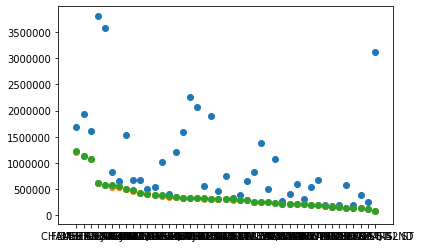

In [137]:
x = final['STATION']
y1 = final['am_diff']
y2 = final['mid_diff']
y3 = final['pm_diff']
plt.scatter(x, y1)
plt.scatter(x, y2)
plt.scatter(x, y3)


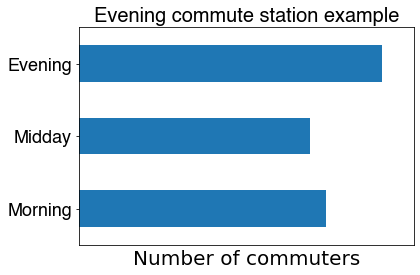

In [112]:
final.iloc[0].drop(['STATION', 'am_v_mid', 'pm_v_mid']).plot.barh()
plt.title('Evening commute station example',fontname = 'Helvetica', fontsize = 20,loc='center',  weight = 'bold');
plt.xlabel('Number of commuters',fontsize = 20);

ticks_x = np.linspace(900000, 990000, 0)
plt.xticks(ticks_x, fontsize = '10', fontname = 'Helvetica');

ticks_y = np.linspace(0, 2, 3)
months = ['Morning','Midday','Evening']
plt.yticks(ticks_y, months, fontsize = '18', fontname = 'Helvetica');


plt.xlim([1300000, 1700000]);

plt.savefig('PM_commute.png')

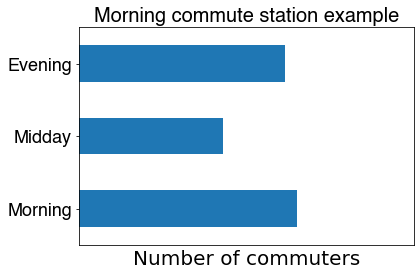

In [100]:
final.iloc[2].drop(['STATION', 'am_v_mid', 'pm_v_mid']).plot.barh()
plt.title('Morning commute station example',fontname = 'Helvetica', fontsize = 20,loc='center',  weight = 'bold');
plt.xlabel('Number of commuters',fontsize = 20);

ticks_x = np.linspace(900000, 990000, 0)
plt.xticks(ticks_x, fontsize = '10', fontname = 'Helvetica');

ticks_y = np.linspace(0, 2, 3)
months = ['Morning','Midday','Evening']
plt.yticks(ticks_y, months, fontsize = '18', fontname = 'Helvetica');


plt.xlim([1300000, 1380000]);
plt.savefig('AM_commute.png')